# Fully-saturated TWFE

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from patsy import dmatrix
import pymc as pm
import arviz as az
az.style.use('arviz-darkgrid')

In [3]:
filepath = '../../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1863 entries, 0 to 1862
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   island_ids                1863 non-null   int64  
 1   year                      1863 non-null   int64  
 2   pseudo_year               1863 non-null   int64  
 3   region_codes              1863 non-null   object 
 4   prefecture_codes          1863 non-null   int64  
 5   population                1723 non-null   float64
 6   treatment_group           1863 non-null   int64  
 7   treatment_group_mainland  1863 non-null   int64  
 8   bridge_year               1863 non-null   int64  
 9   pseudo_bridge_year        1863 non-null   int64  
 10  after_treatment           1863 non-null   int64  
 11  connect_mainland_year     1863 non-null   int64  
 12  after_treatment_mainland  1863 non-null   int64  
 13  income                    1401 non-null   float64
 14  area_km2

## 階層ベイズモデル 不均一分散

$$
\begin{aligned}
\log{Y^{**}_{it}} &\sim \mathcal{t} (\nu, \mu_{it}, \sigma_i^2) \\
\nu &\sim \text{Exponential}(1/10) \\
\mu_{it} &= \beta_{gl} \cdot T_{i} \\
\beta_{gl} &\sim \mathcal{N}(\mu_{\beta}, \sigma_{\beta}^2) \\
\sigma_i &\sim \mathcal{C}^+(\sigma_0^2) \\
\end{aligned}
$$

- $\beta_{gl}$: 介入時期 $g$ と介入経過時間 $l$ によって変動する介入効果
- $T_{it}$: 介入群ダミー
- $\mu_{\beta}$: 介入時期と介入経過時間の期待値を表すハイパーパラメータ
- $\sigma_{\beta}^2$: 介入時期と介入経過時間の分散を表すハイパーパラメータ
- $\sigma_0^2$: 島間の誤差分散を表すハイパーパラメータ
- $\sigma_i^2$: 島間の誤差分散

/home/keisei/data-analysis/.venv/lib/python3.12/site-packages/pymc/model/core.py:1302: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


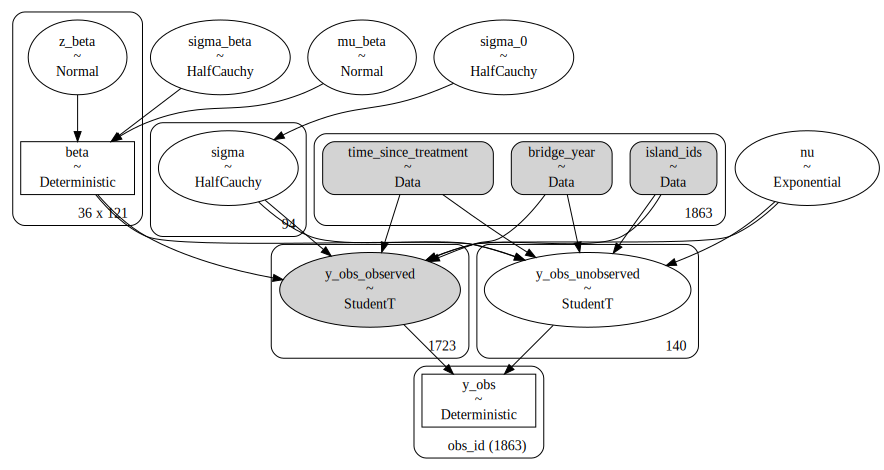

In [ ]:
# 0から始まるインデックスを振り直す
island_ids, unique_island_ids = pd.factorize(df['island_ids'])
n_islands = len(unique_island_ids)
bridge_year, unique_bridge_year = pd.factorize(df['bridge_year'])
n_bridge_year = len(unique_bridge_year)
time_since_treatment, unique_time_since_intervention = pd.factorize(df['time_since_treatment'])
n_time_since_intervention = len(unique_time_since_intervention)

COORDS = {'obs_id': df.index}

with pm.Model(coords=COORDS) as model_h_hetero:
    # data
    island_ids = pm.Data('island_ids', island_ids)
    bridge_year = pm.Data('bridge_year', bridge_year)
    time_since_treatment = pm.Data('time_since_treatment', time_since_treatment)

    # priors
    # ATT
    mu_beta = pm.Normal('mu_beta', mu=0, sigma=1)
    sigma_beta = pm.HalfCauchy('sigma_beta', beta=1)
    z_beta = pm.Normal('z_beta', mu=0, sigma=1, shape=(n_bridge_year, n_time_since_intervention))
    beta = pm.Deterministic('beta', mu_beta + sigma_beta * z_beta)

    # sigma
    sigma_0 = pm.HalfCauchy('sigma_0', beta=1)
    sigma = pm.HalfCauchy('sigma', beta=sigma_0, shape=n_islands)

    # nu
    nu = pm.Exponential('nu', lam=1/30)

    # expected value
    mu = beta[bridge_year, time_since_treatment] + sigma[island_ids]

    # likelihood
    y_obs = pm.StudentT('y_obs', mu=mu, sigma=sigma[island_ids], nu=nu, observed=df['log_pop_star'], dims='obs_id')

pm.model_to_graphviz(model_h_hetero)

In [ ]:
with model_h_hetero:
    trace_h_hetero = pm.

In [15]:
az.summary(trace_fully_saturated, var_names=['intercept', 'delta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,341.206,23.924,294.683,384.505,1.424,1.012,283.0,491.0,1.01
delta,97.289,25.809,47.479,144.239,0.992,0.702,676.0,1252.0,1.00
sigma,130.766,7.523,116.691,144.708,0.283,0.201,719.0,1126.0,1.00


In [16]:
az.waic(trace_fully_saturated)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -13433.01   177.39
p_waic      164.55        -

There has been a warning during the calculation. Please check the results.

In [ ]:
# デルタのサマリーを取得
delta_df = az.summary(trace_fully_saturated, var_names=['delta'], hdi_prob=0.95, kind='stats')
# 正規表現を使用してインデックスから介入年と経過年数を抽出
extracted = delta_df.index.to_series().str.extract(r'delta\[(\d+),\s*(\d+)\]')

delta_df['treat'] = extracted[0].astype(int)
delta_df['since_treat'] = extracted[1].astype(int)

df = pd.read_excel(filepath)
year_bridges_opened = df['year_bridges_opened'].unique()
treat = delta_df['treat'].unique()

year_bridges_opened, treat

delta_df['treat'] = delta_df['treat'].map(dict(enumerate(year_bridges_opened)))

time_since_intervention = df['time_since_intervention'].unique()
since_treat = delta_df['since_treat'].unique()

delta_df['since_treat'] = delta_df['since_treat'].map(dict(enumerate(time_since_intervention)))


In [ ]:
# delta_df.to_excel('../../../../../data/processed/delta.csv', index=False)
# 経過年数
# time_since_intervention_list = df['time_since_intervention'].unique()
# time_since_intervention_df = pd.DataFrame(time_since_intervention_list, columns=['time_since_intervention'])

# デルタの値を経過年数と結合
# デルタの順番は経過年数の昇順ではなく，データに登場した順番になっている．
# delta_df.reset_index(drop=True, inplace=True)
# delta_df = pd.concat([delta_df, time_since_intervention_df], axis=1)

In [37]:
delta_df

,mean,sd,hdi_2.5%,hdi_97.5%,treat,since_treat
"delta[0, 0]",0.480,98.049,-189.389,187.379,1999,-29
"delta[0, 1]",-8.763,70.228,-144.471,130.571,1999,-24
"delta[0, 2]",-12.369,79.961,-172.237,137.282,1999,-19
"delta[0, 3]",-9.441,83.355,-168.470,159.805,1999,-14
"delta[0, 4]",-11.009,79.916,-168.883,144.943,1999,-9
...,...,...,...,...,...,...
"delta[35, 131]",-1.510,96.513,-184.775,192.390,1957,58
"delta[35, 132]",0.336,98.398,-208.691,175.208,1957,63
"delta[35, 133]",0.441,100.498,-196.341,193.988,1957,68
"delta[35, 134]",1.650,99.732,-198.903,191.922,1957,46


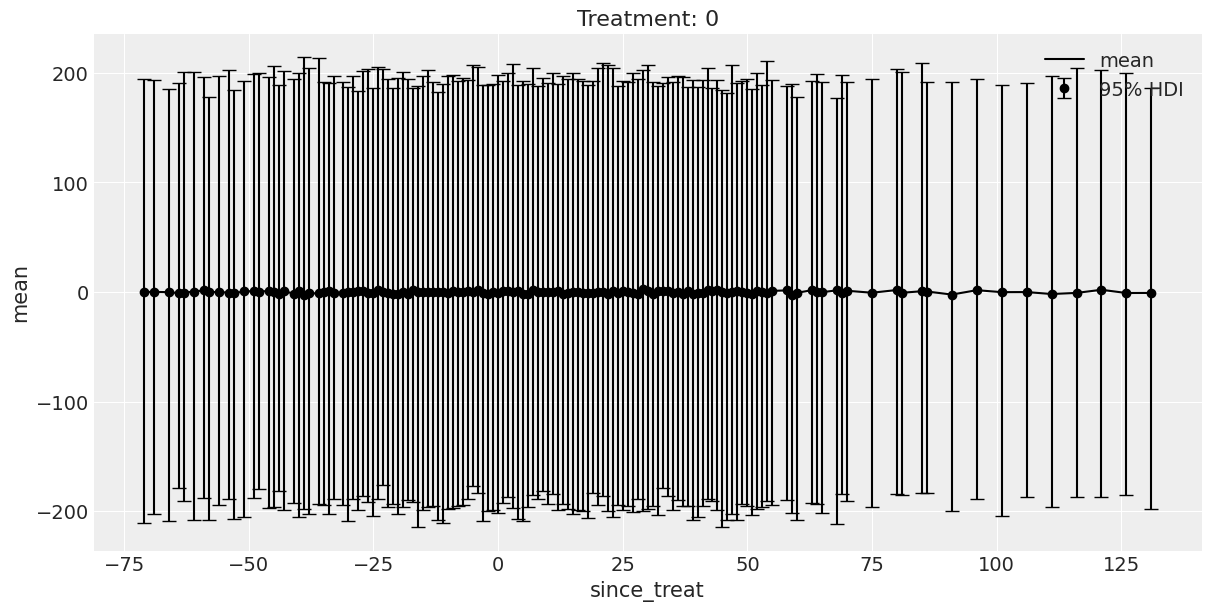

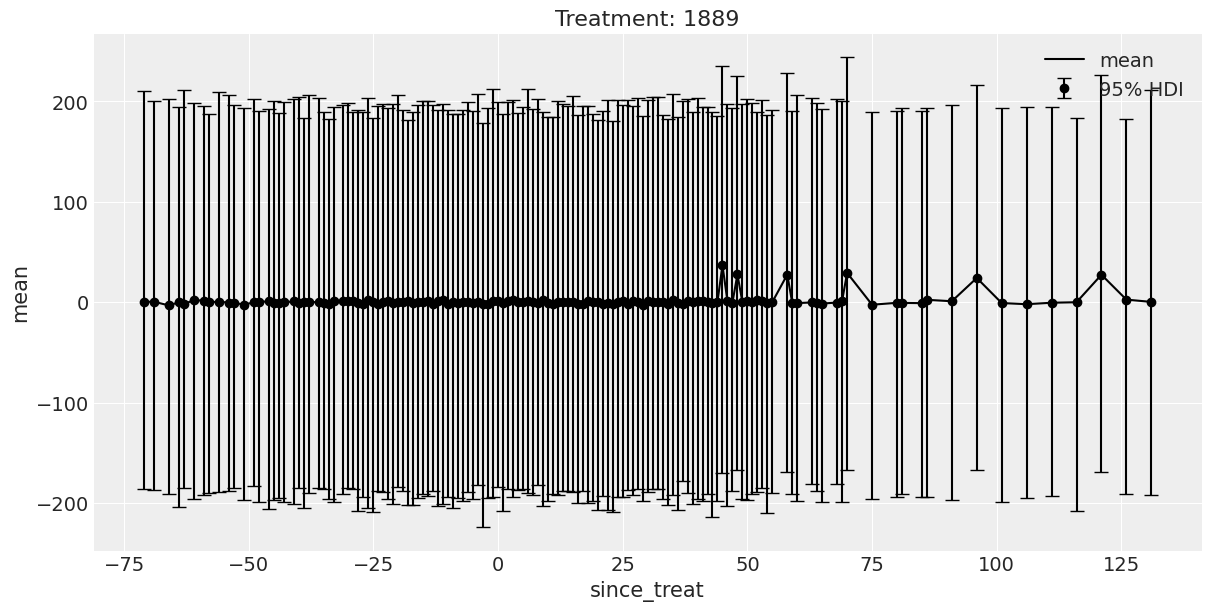

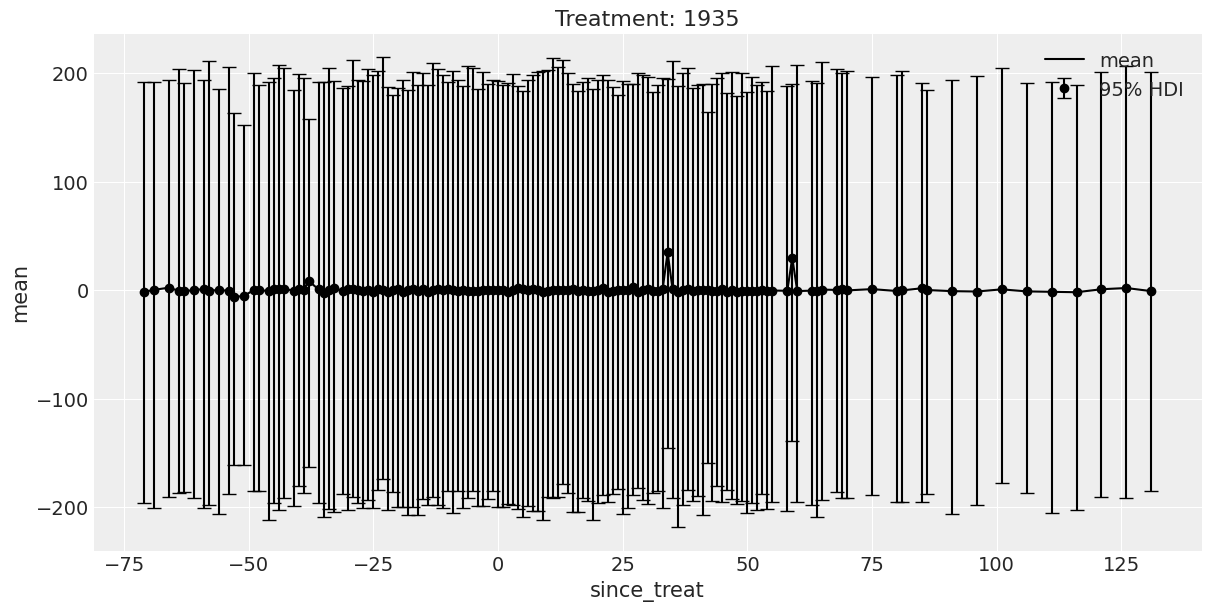

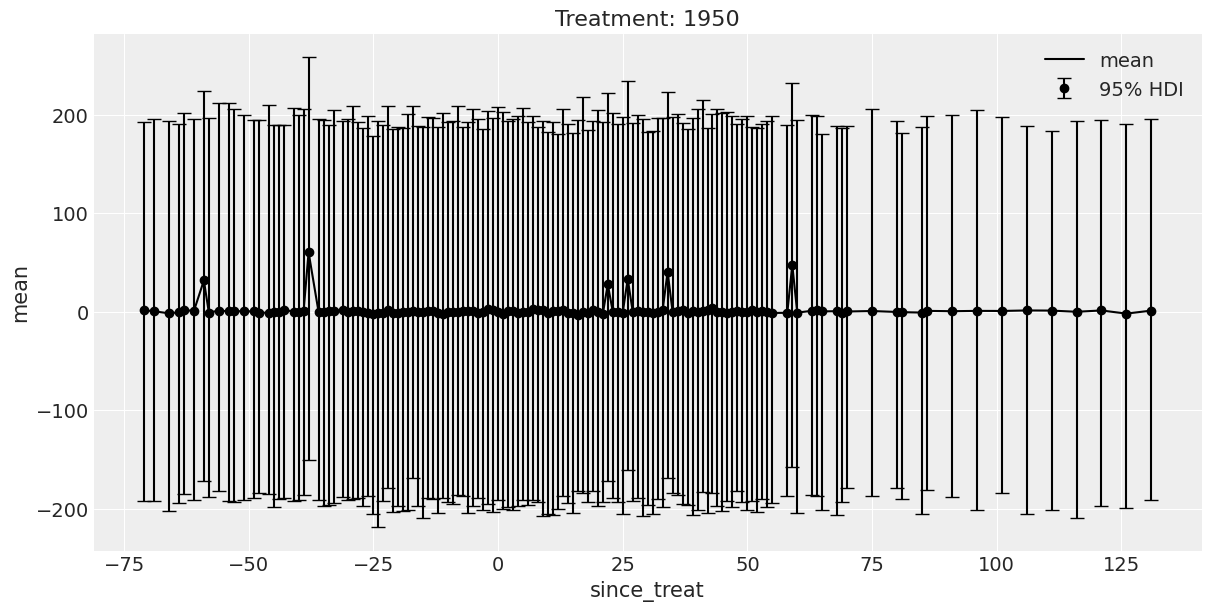

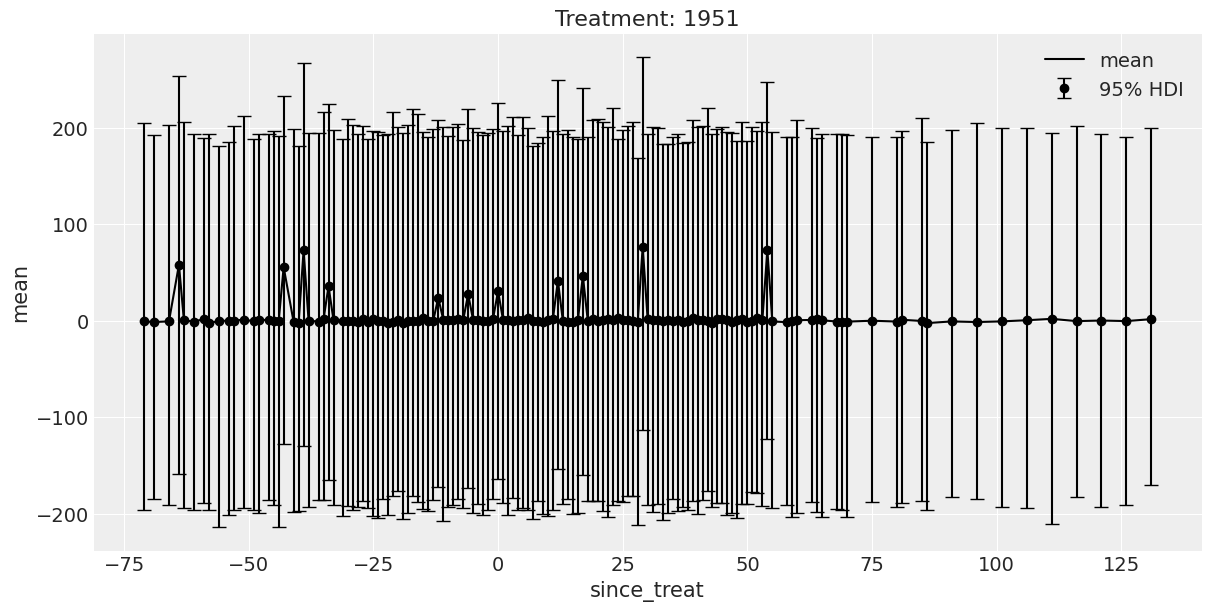

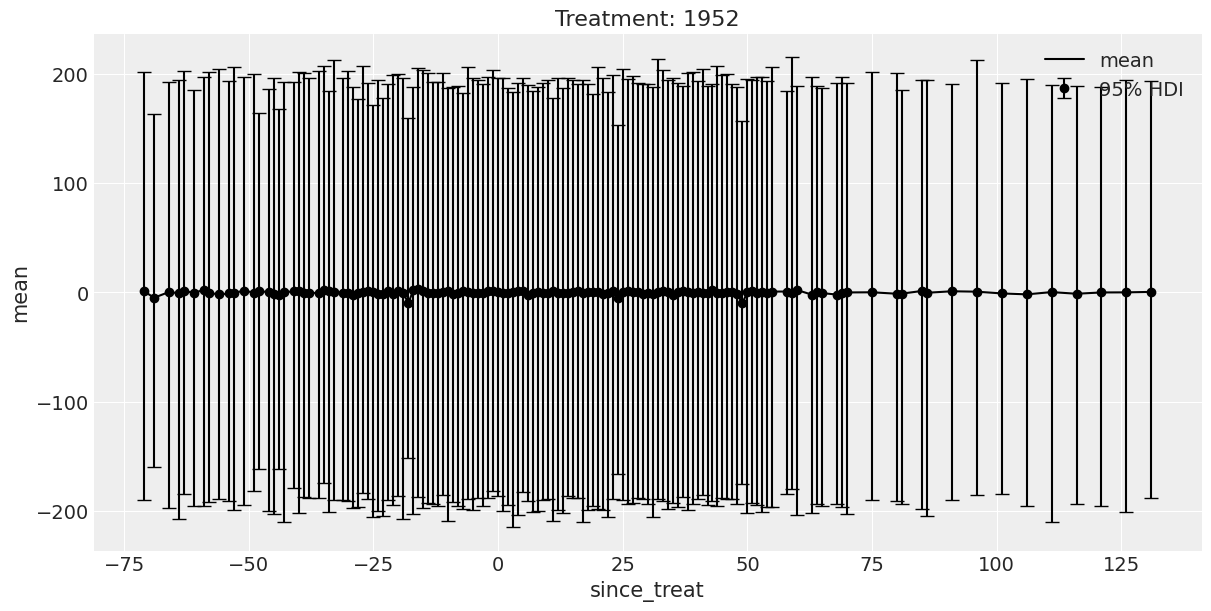

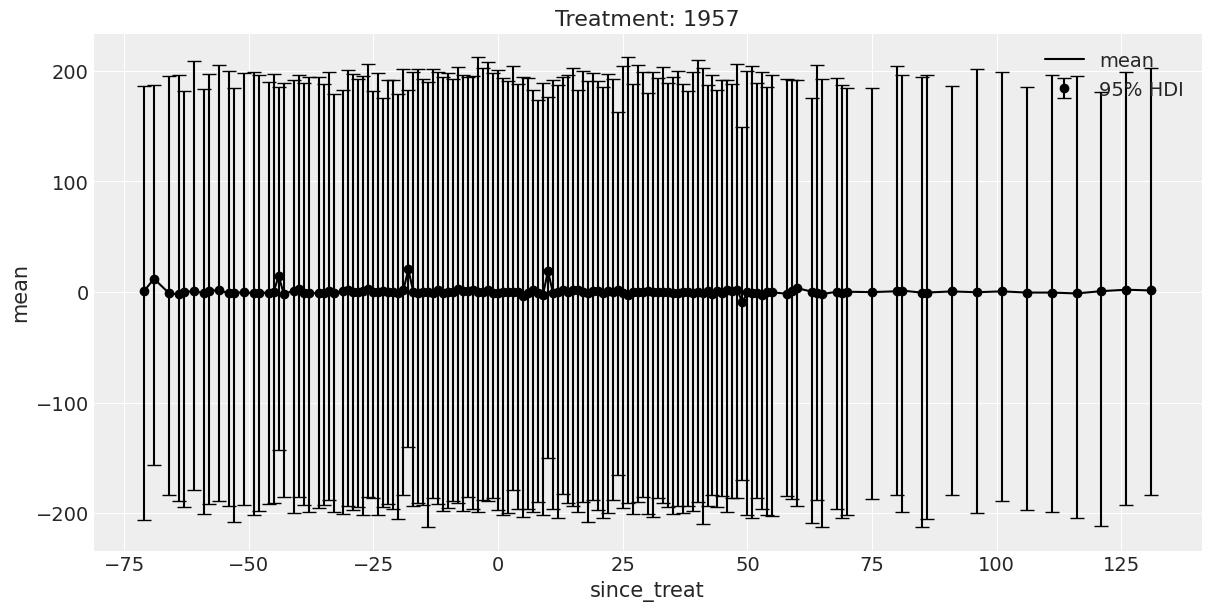

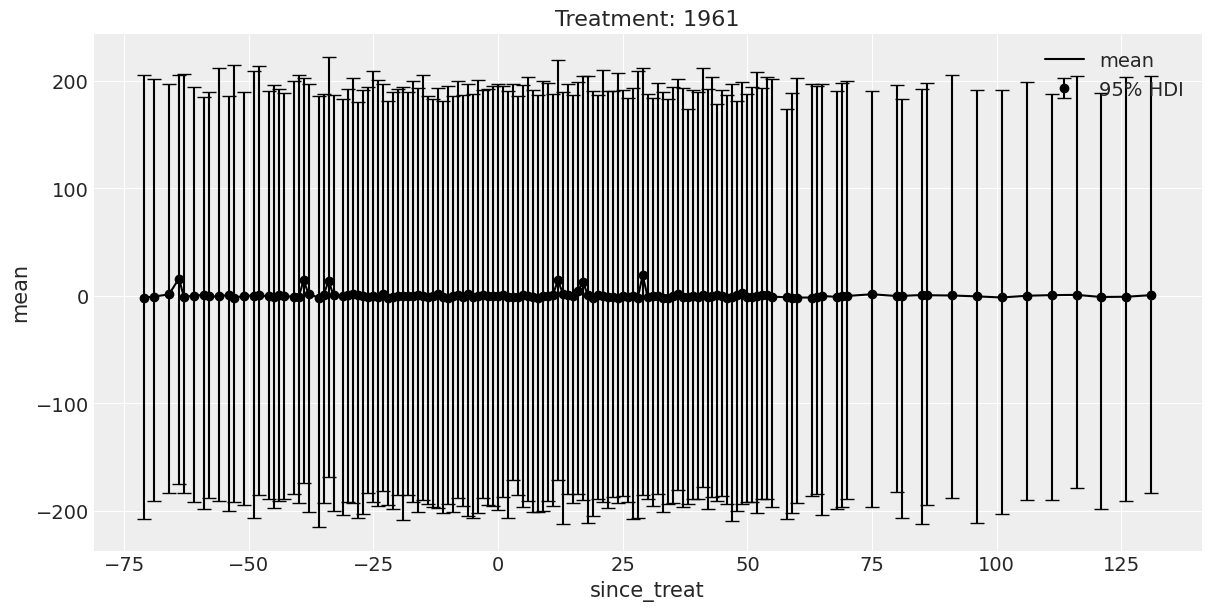

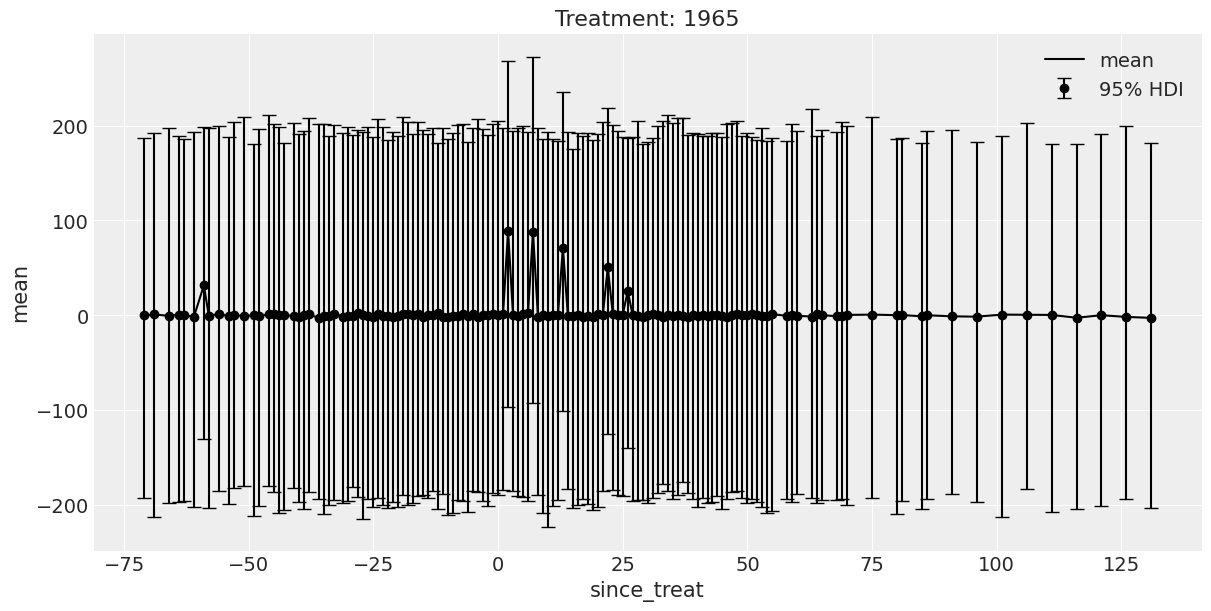

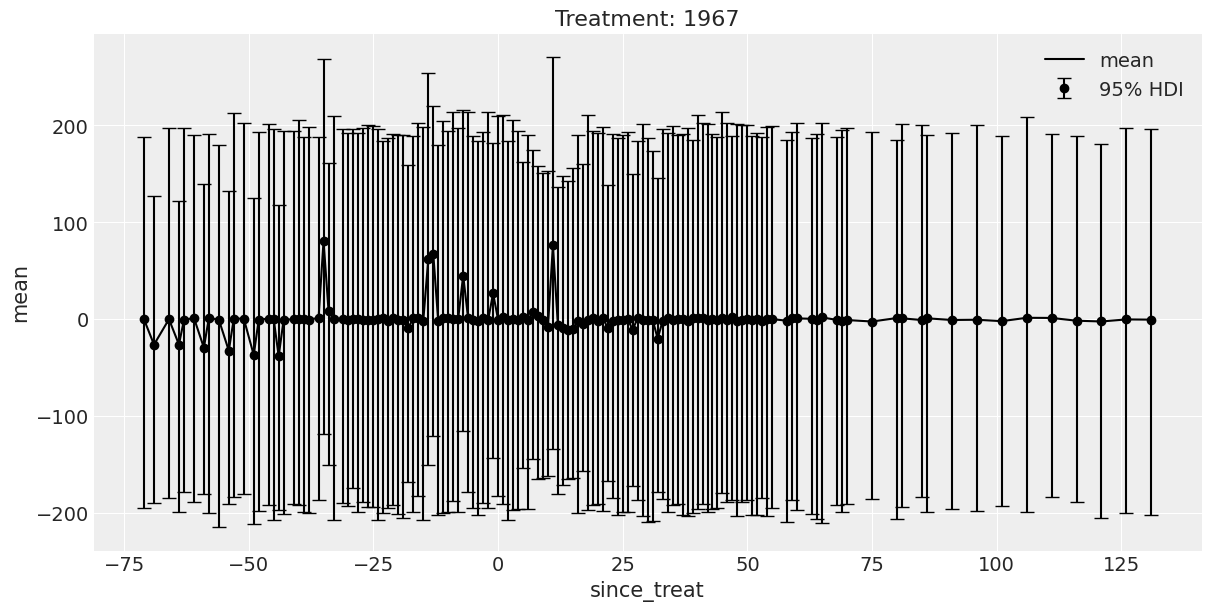

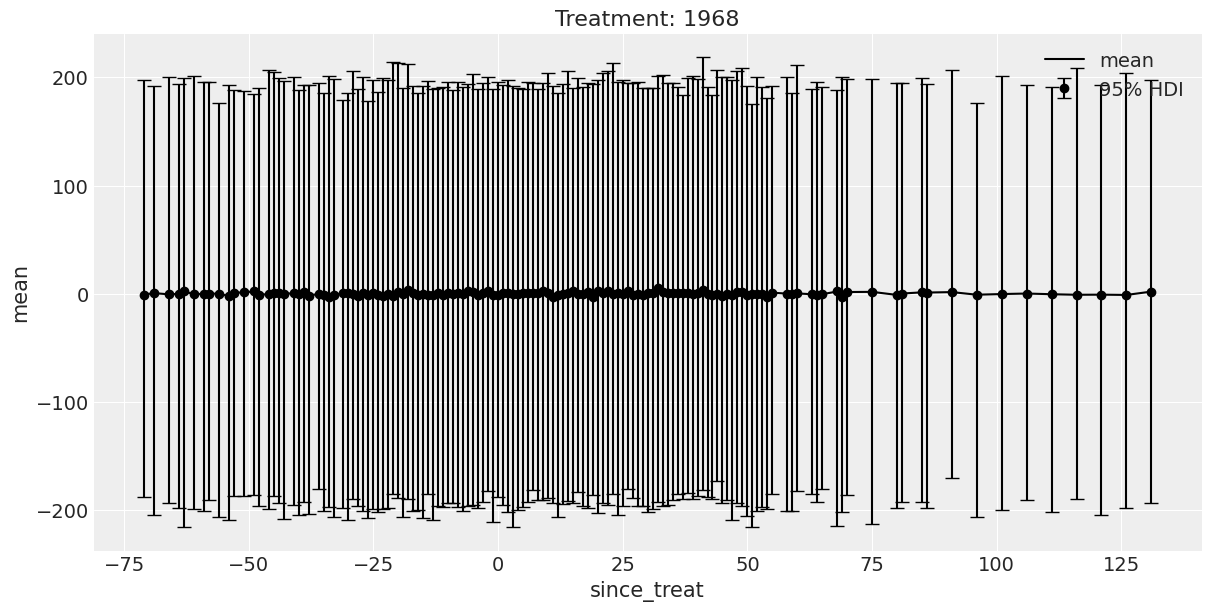

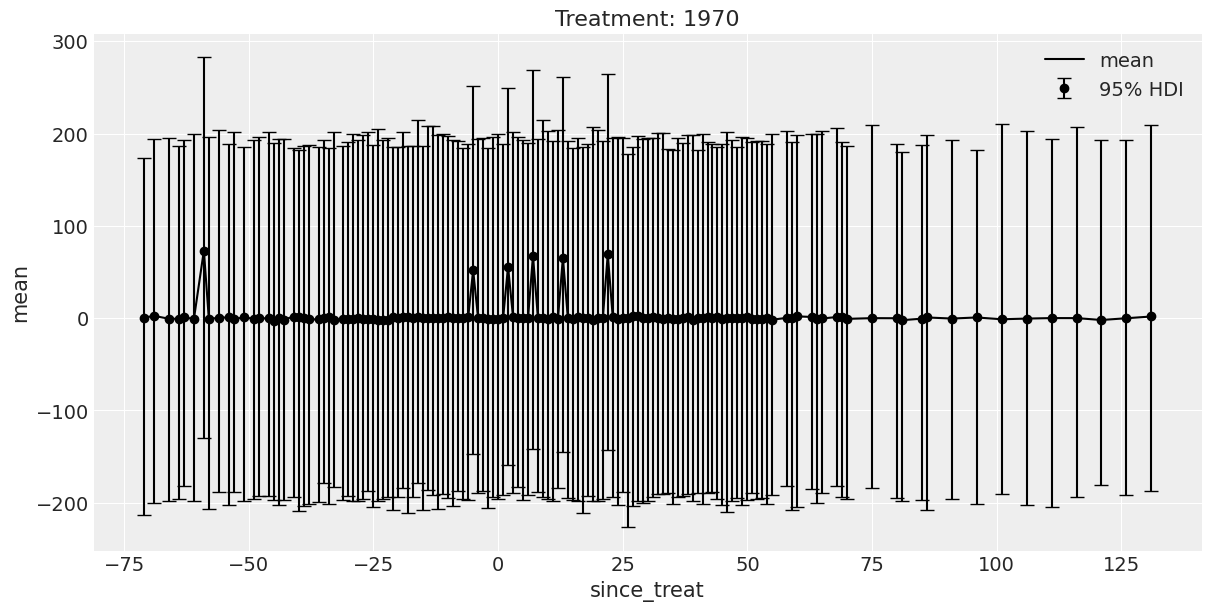

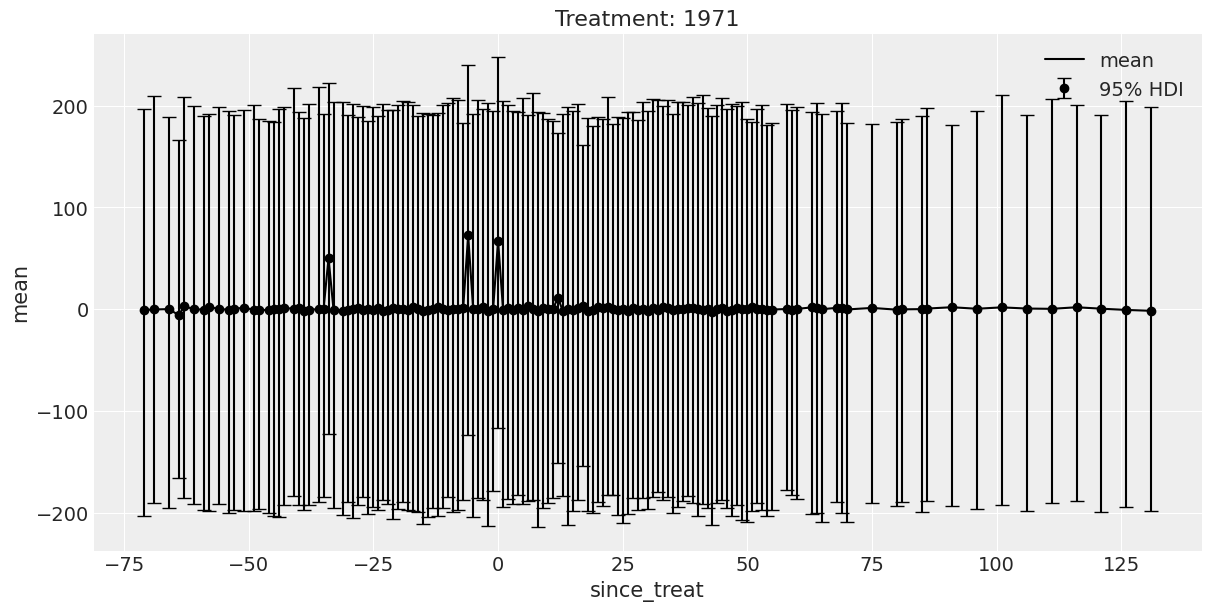

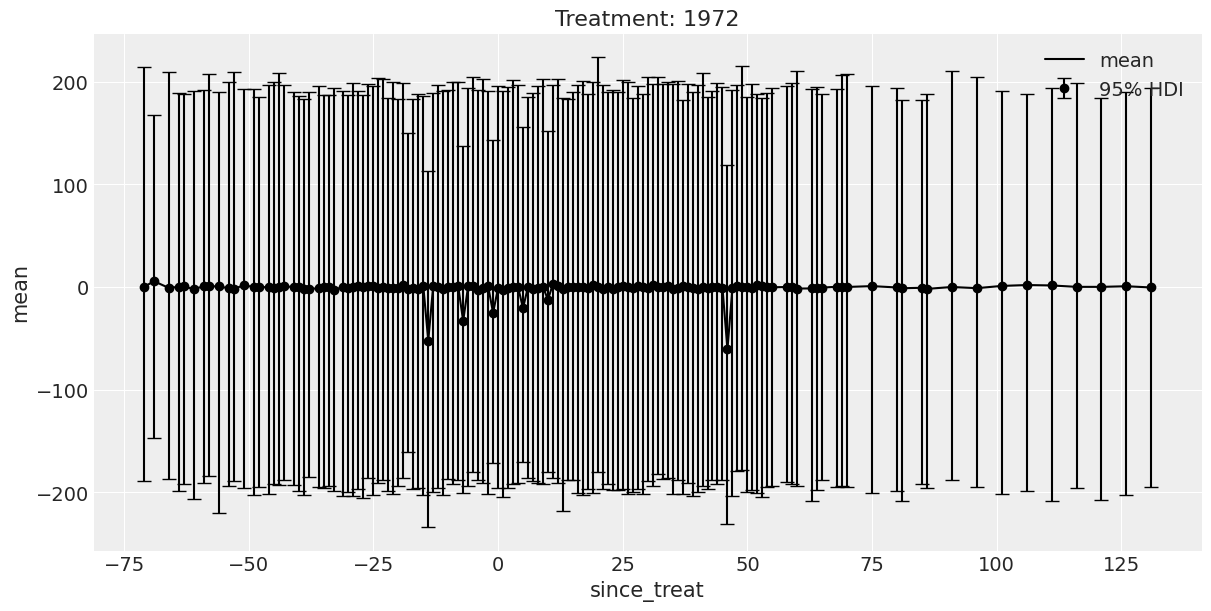

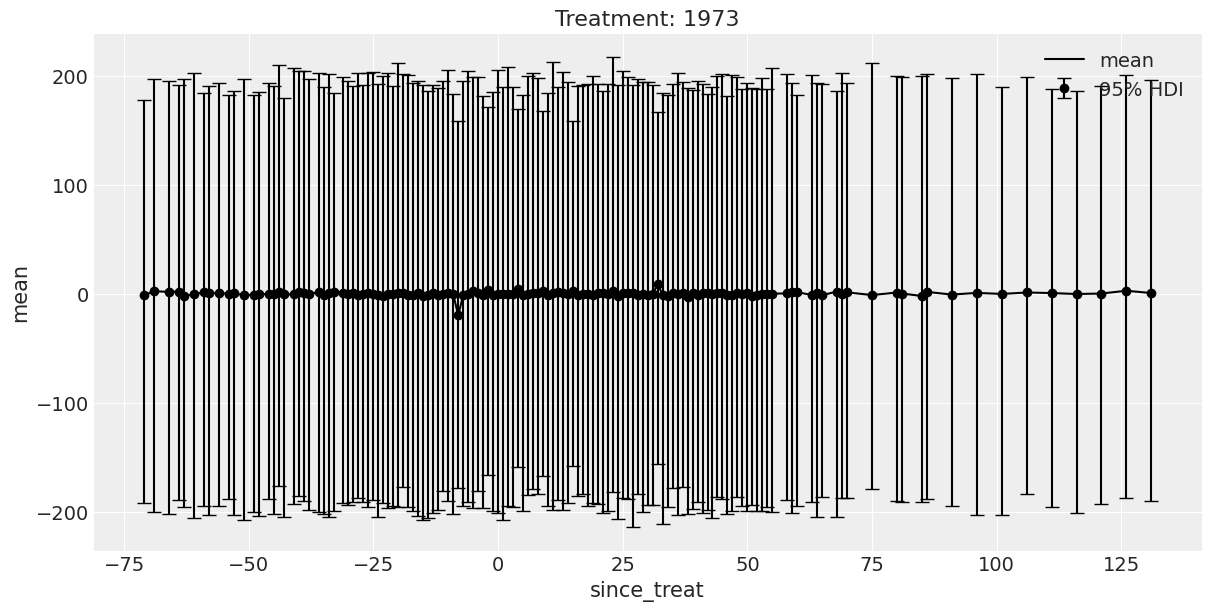

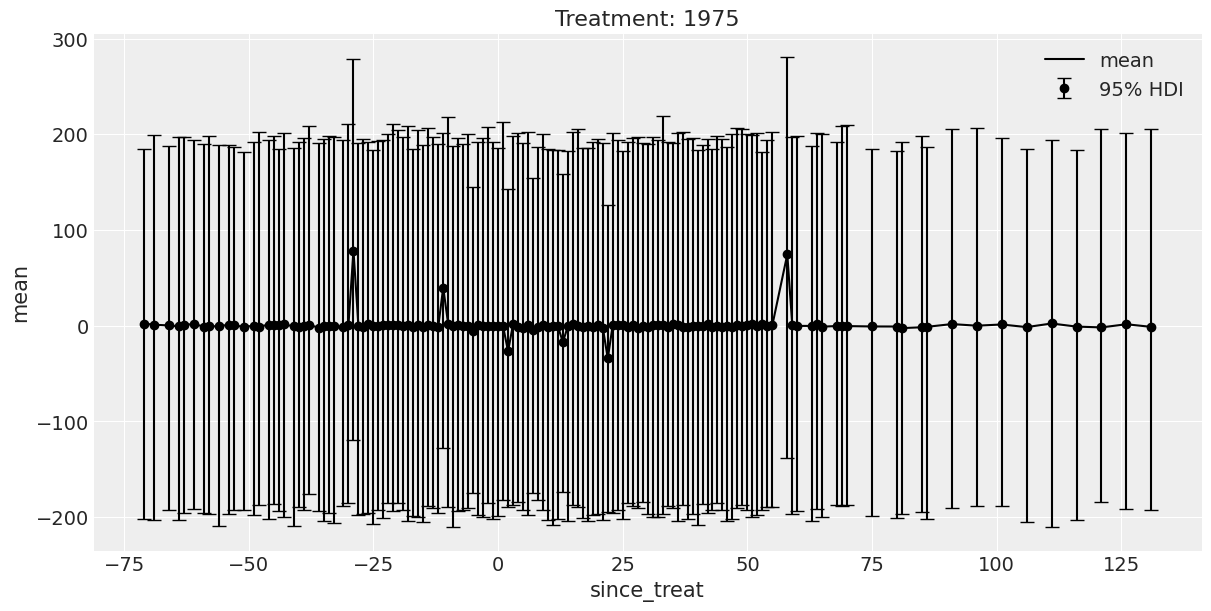

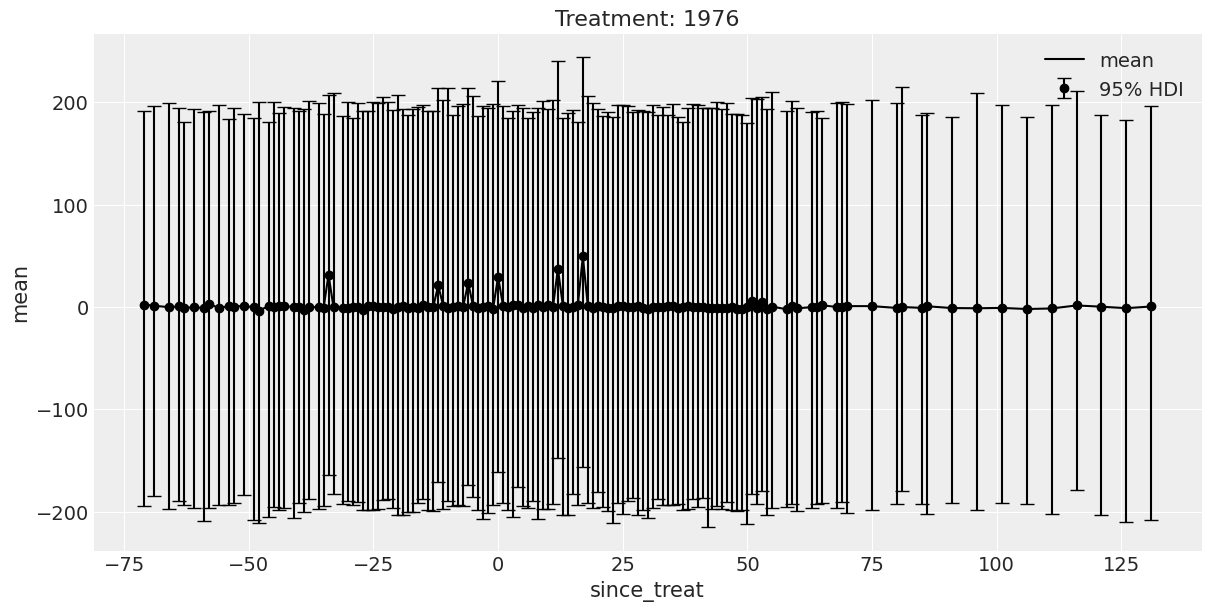

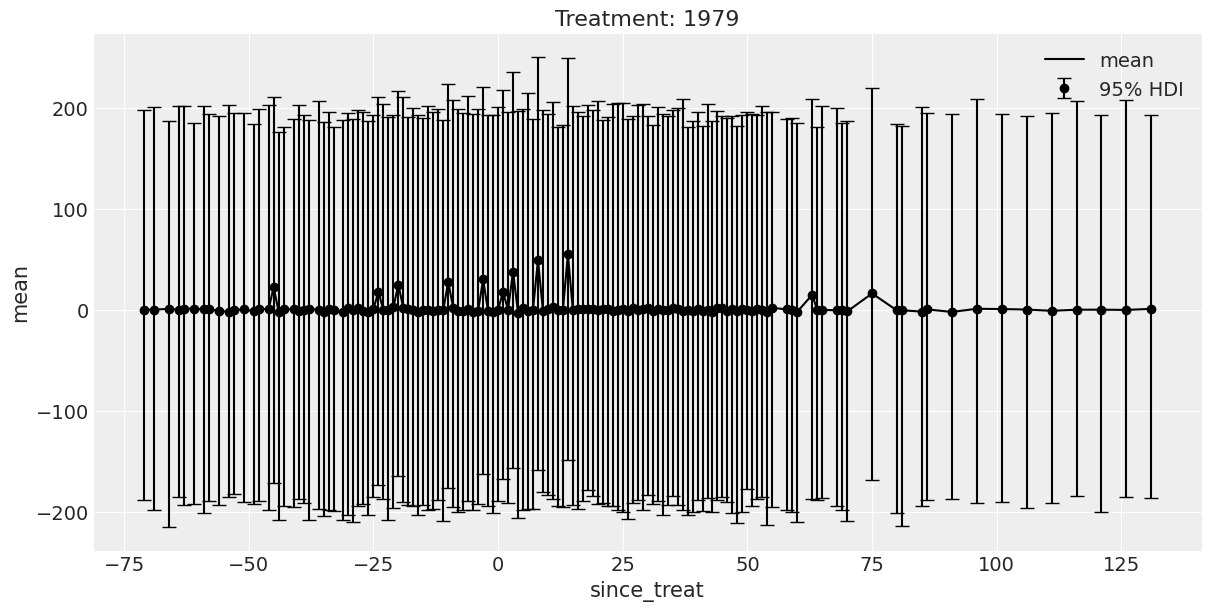

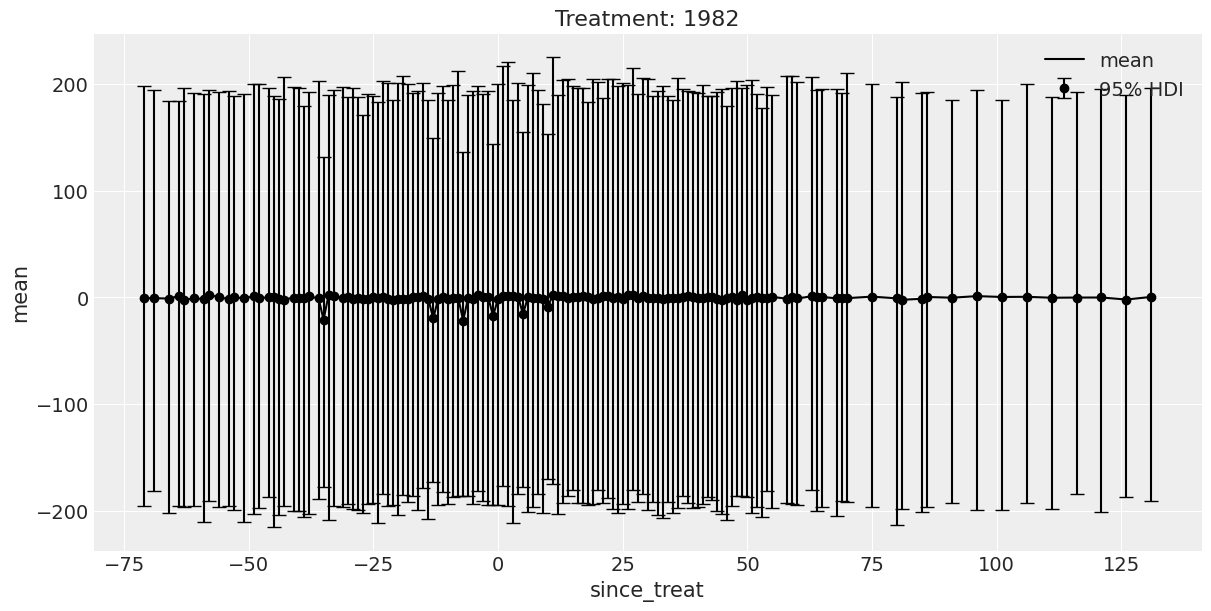

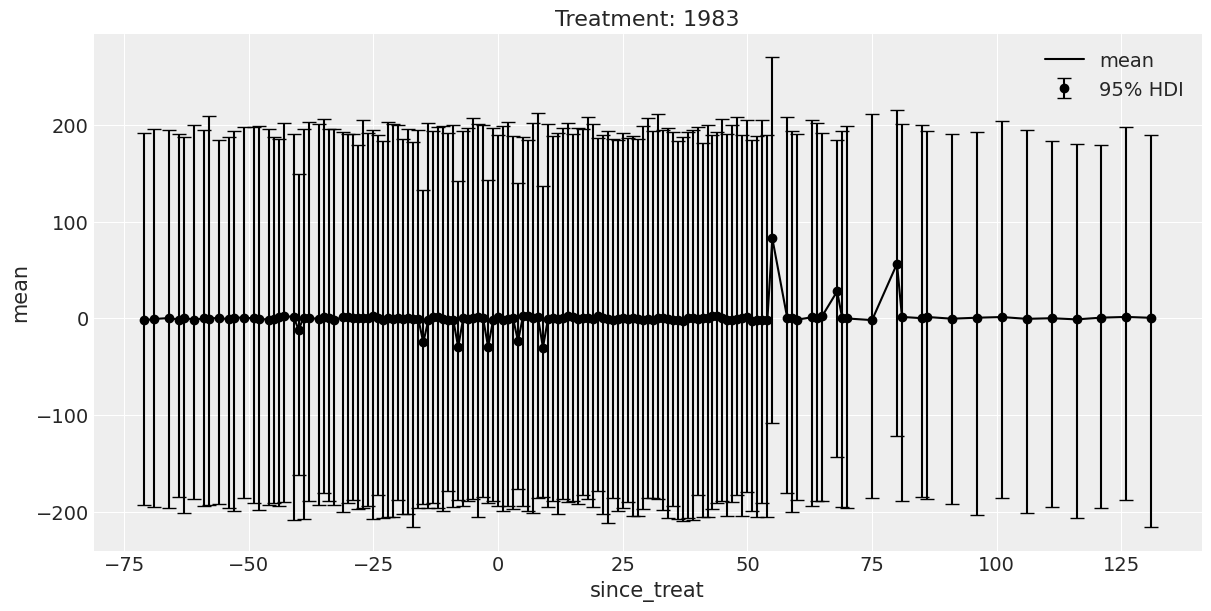

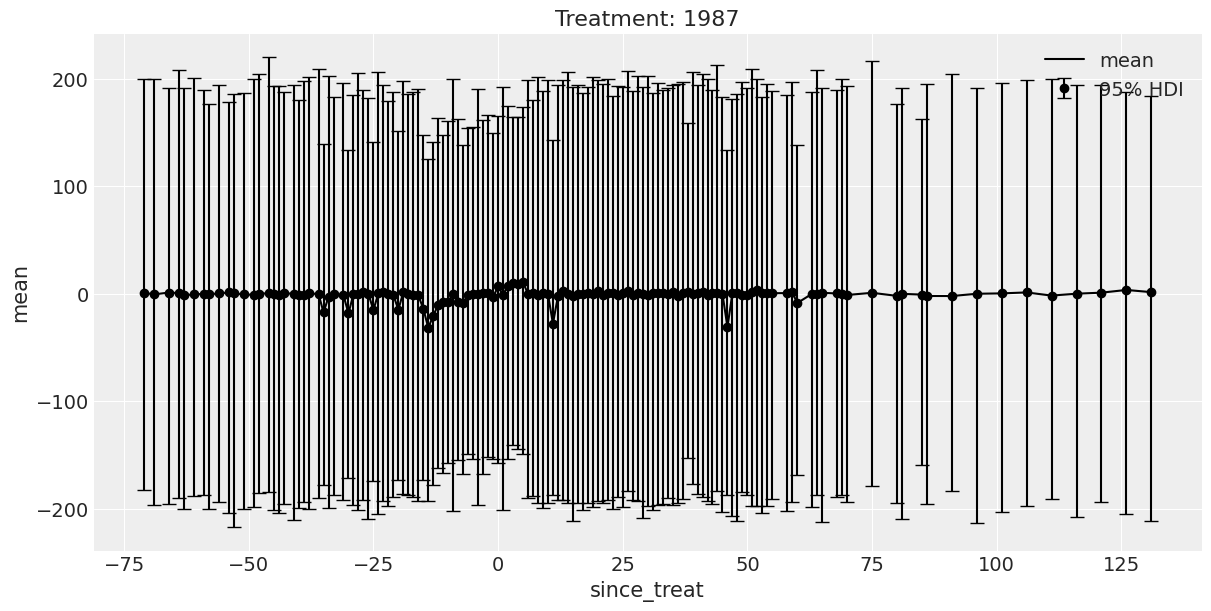

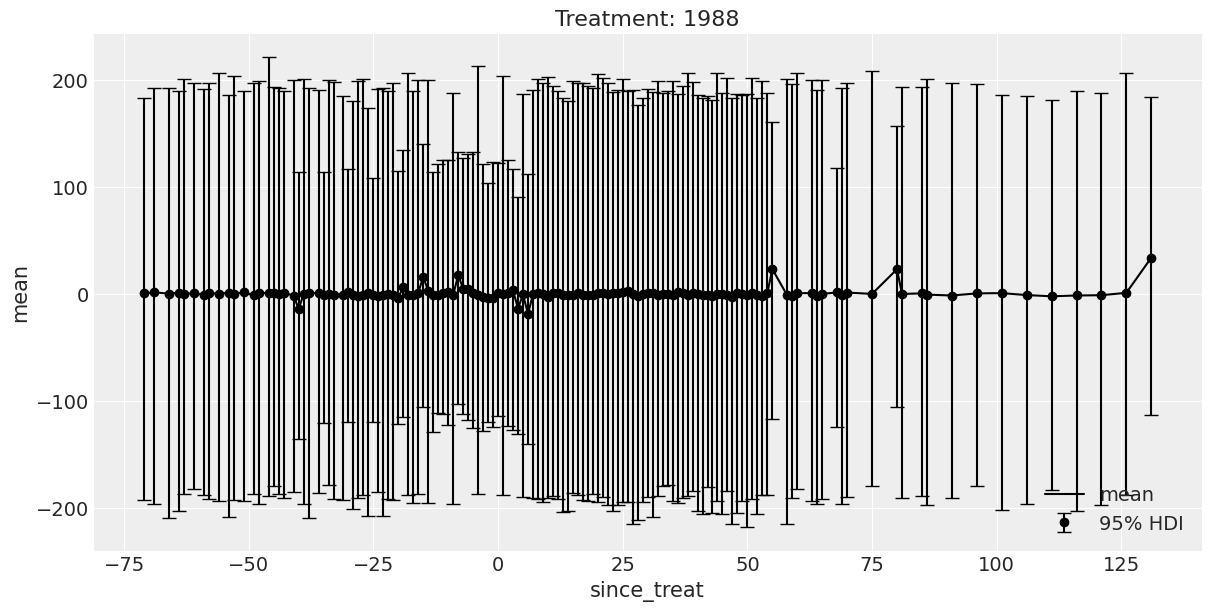

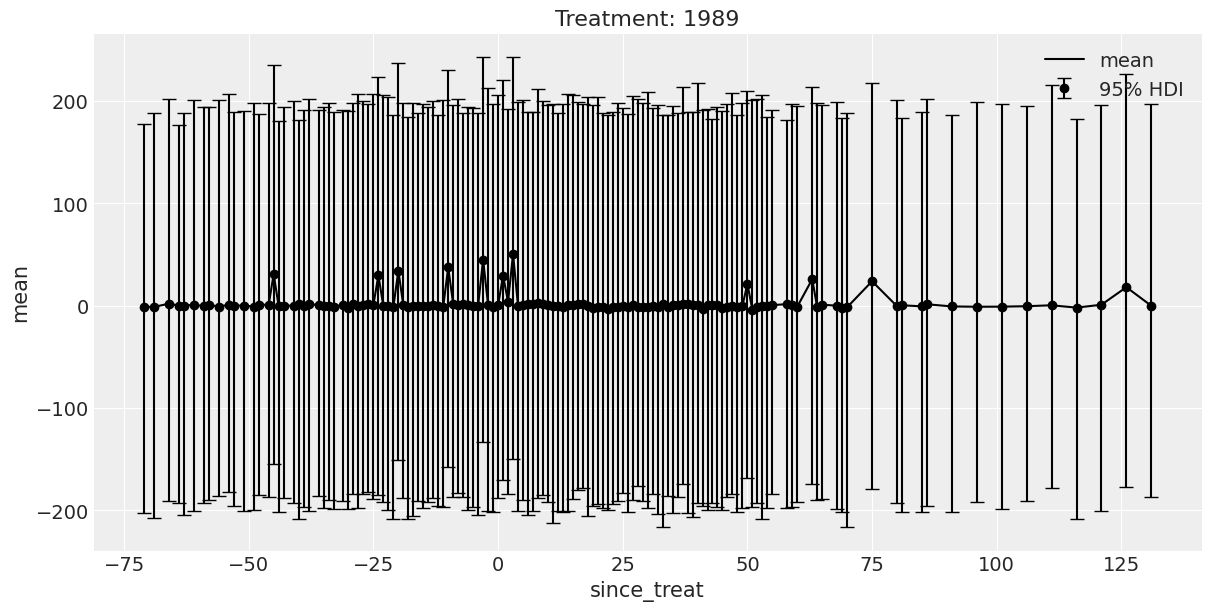

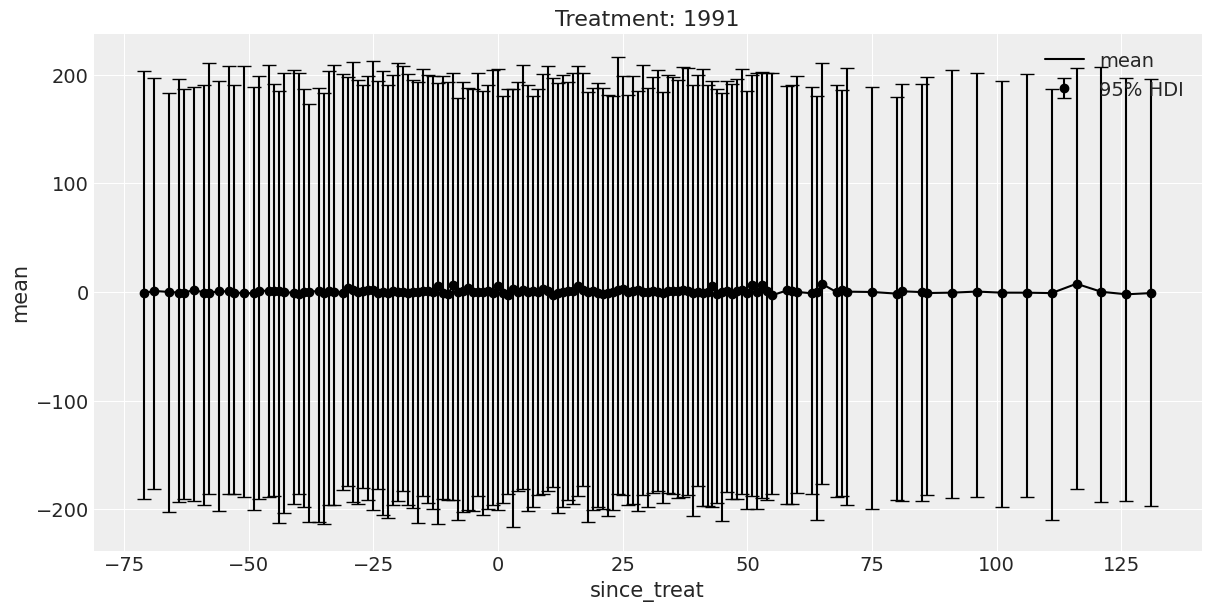

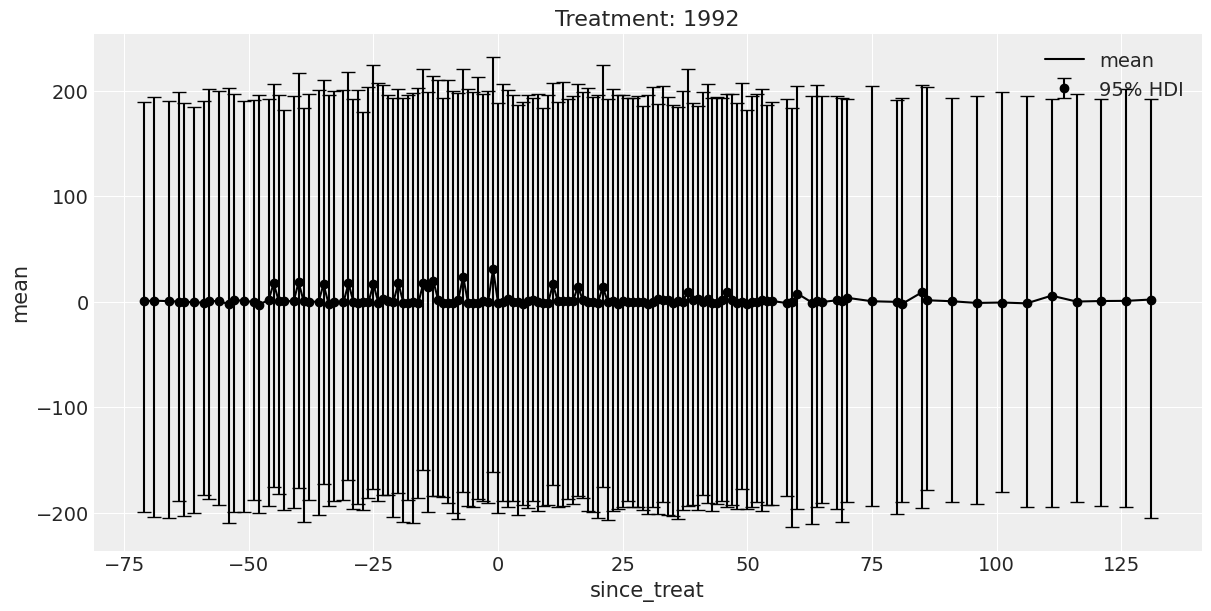

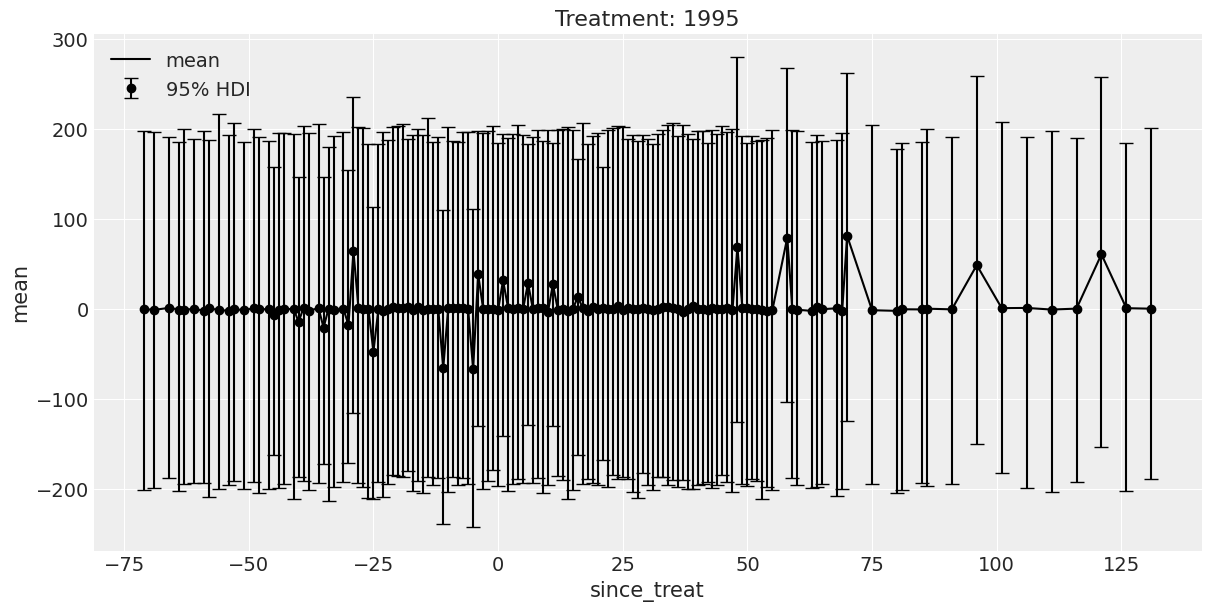

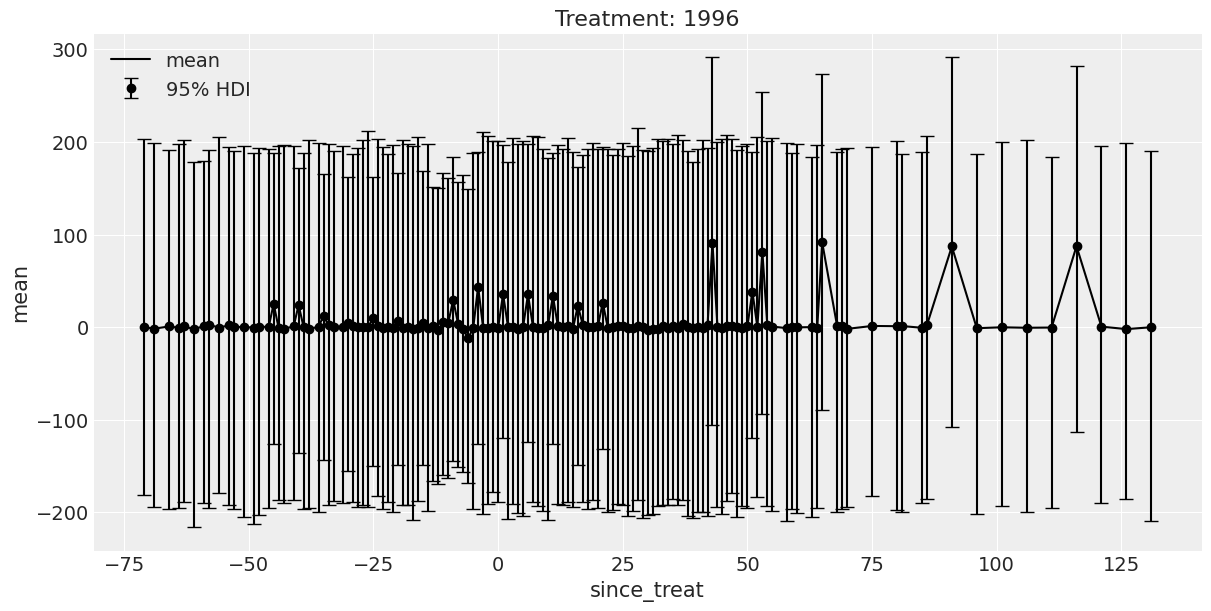

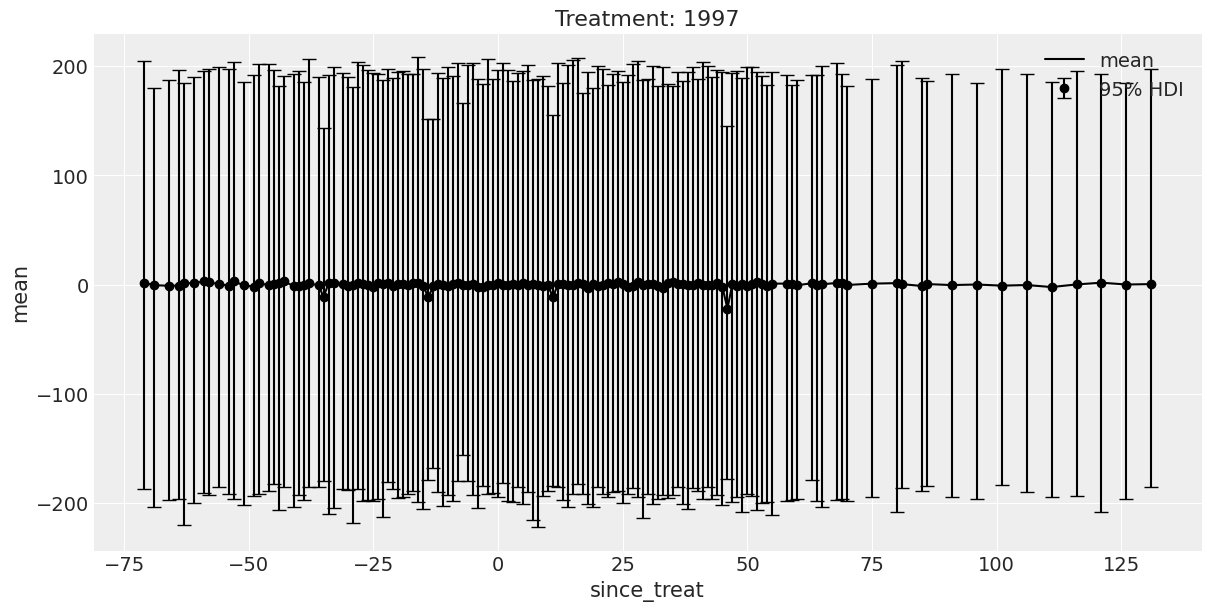

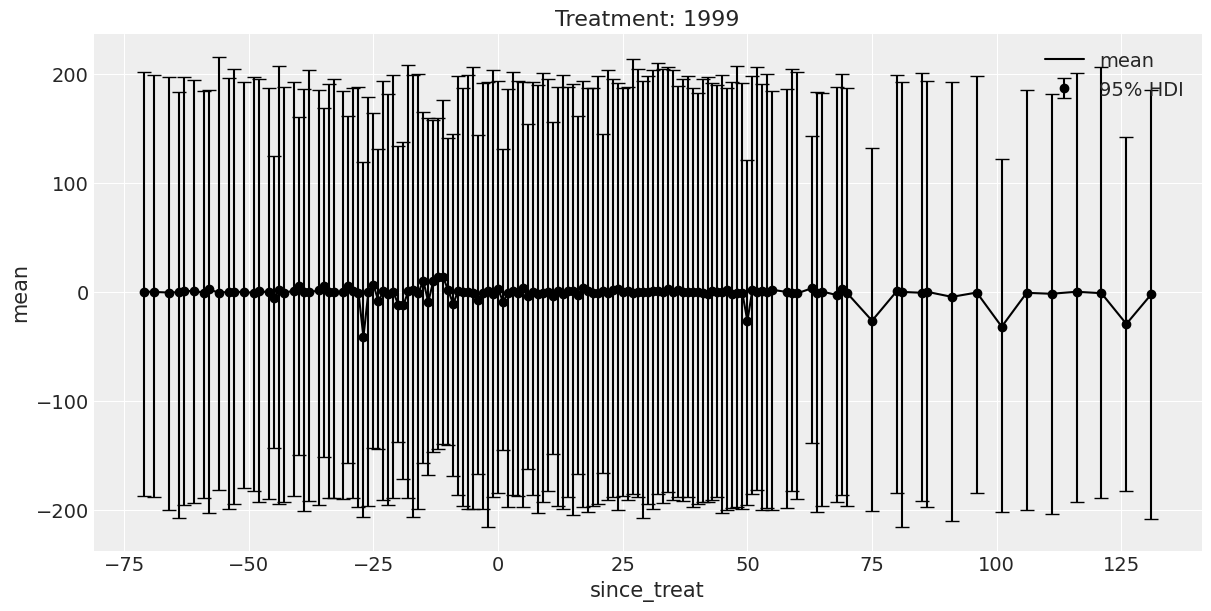

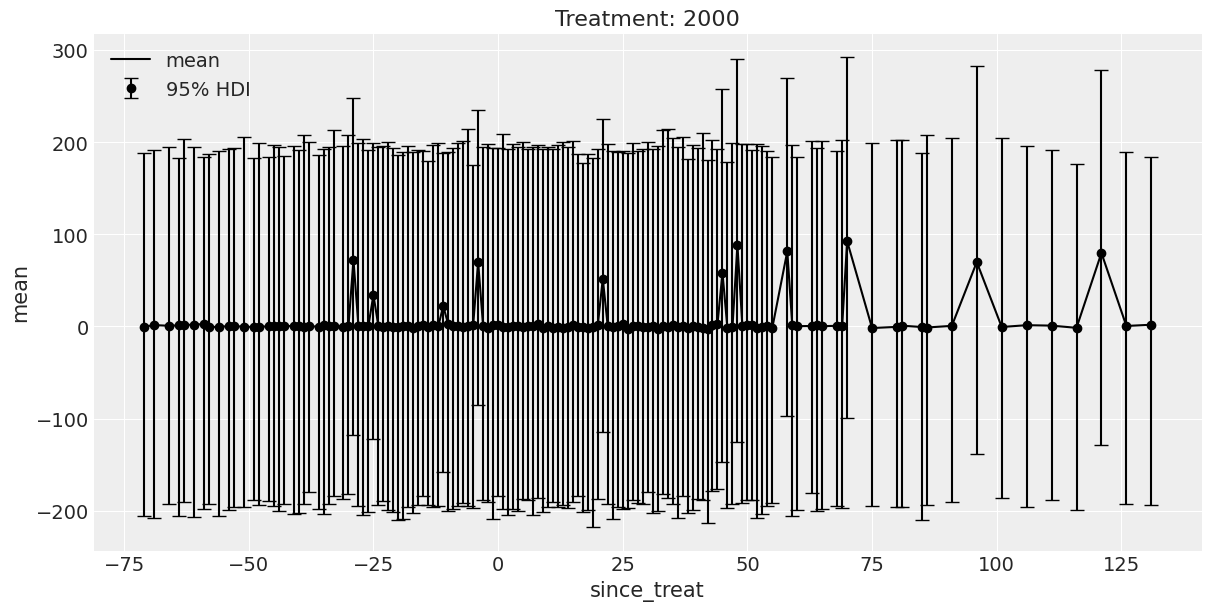

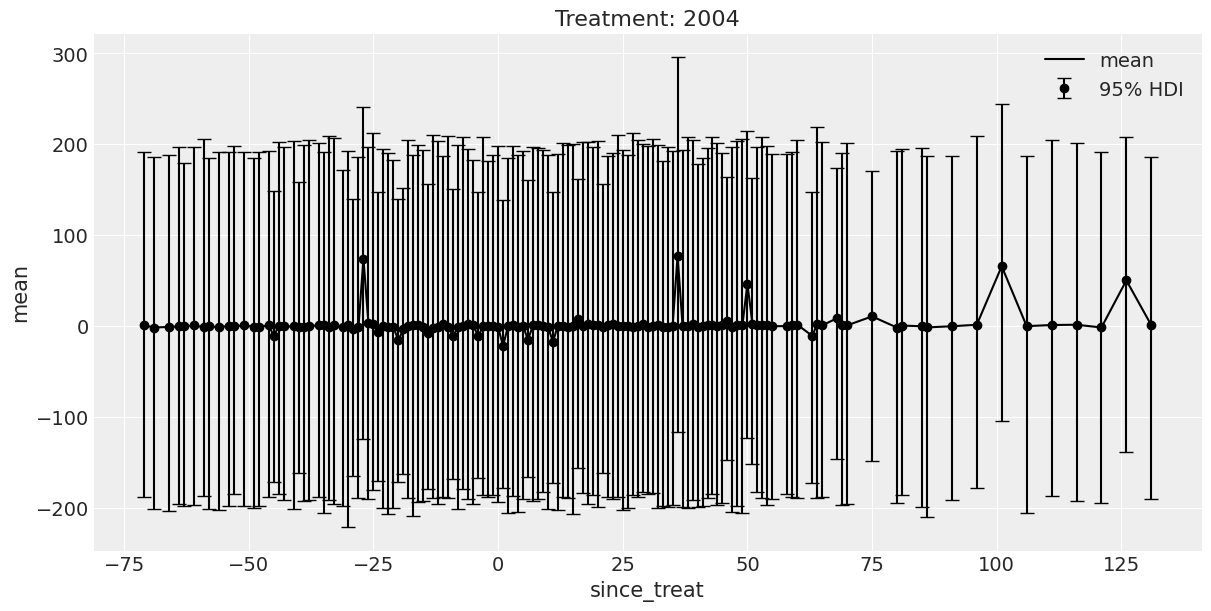

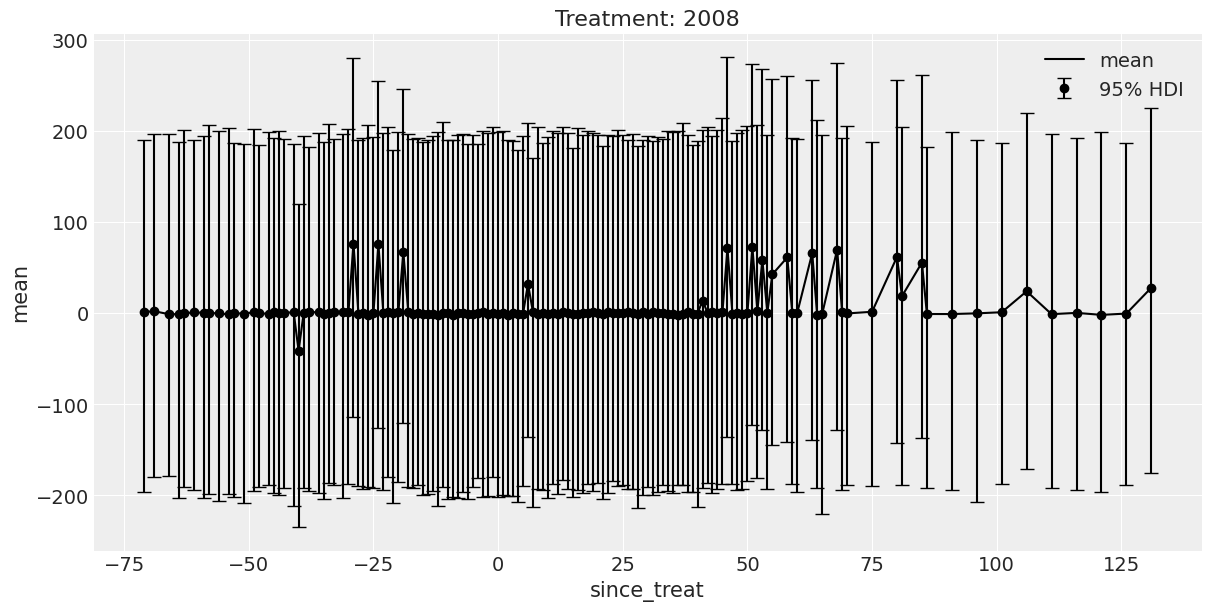

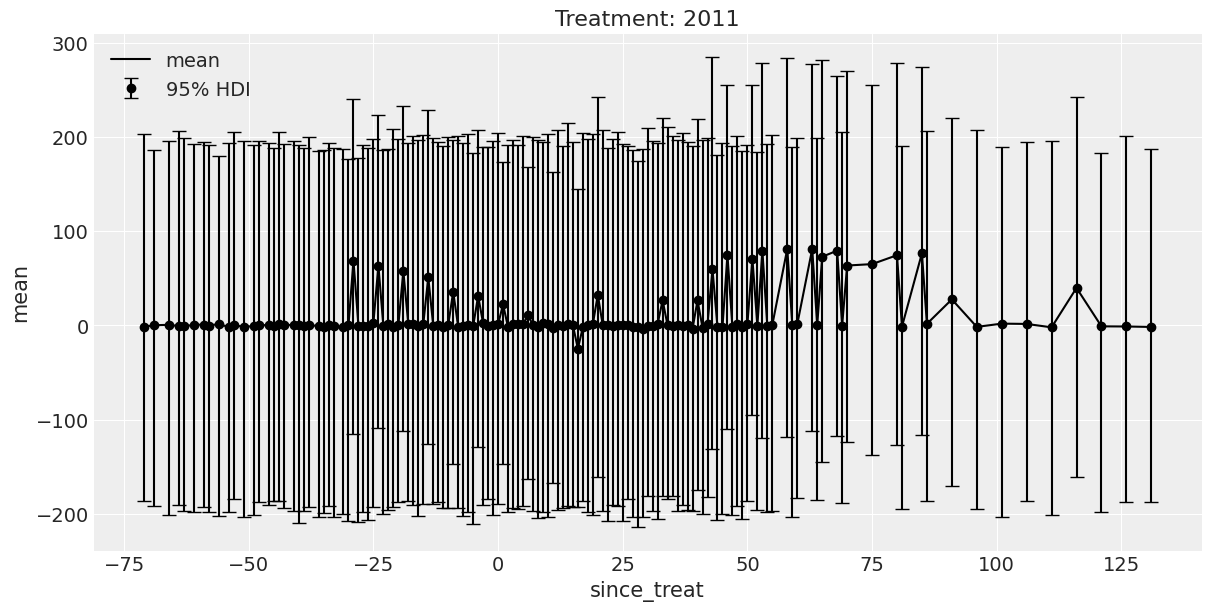

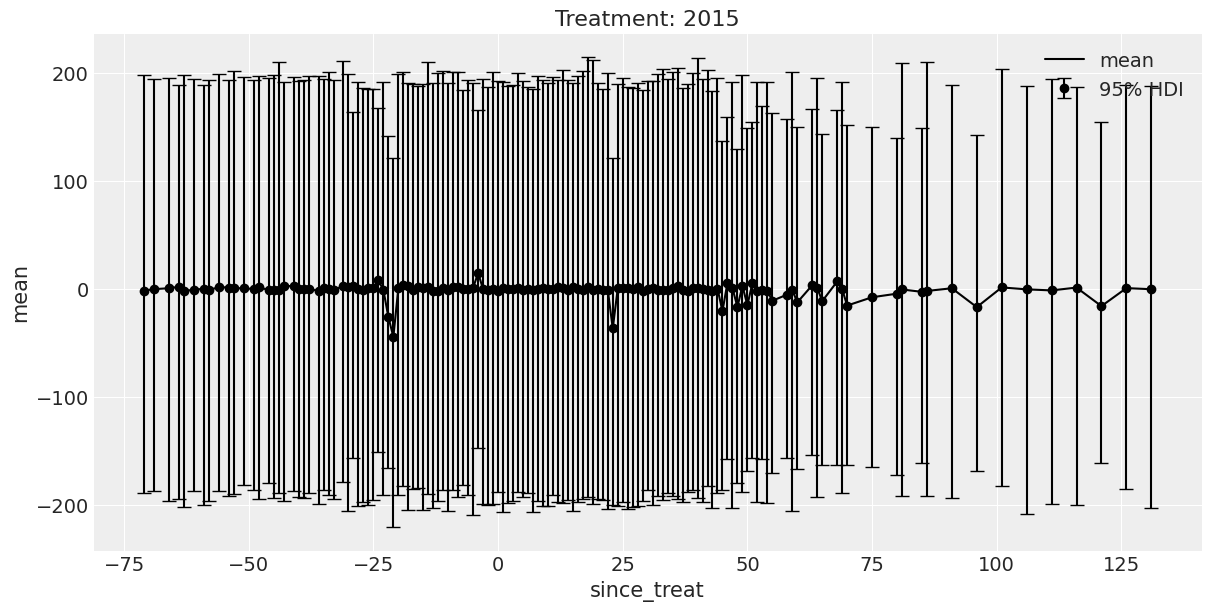

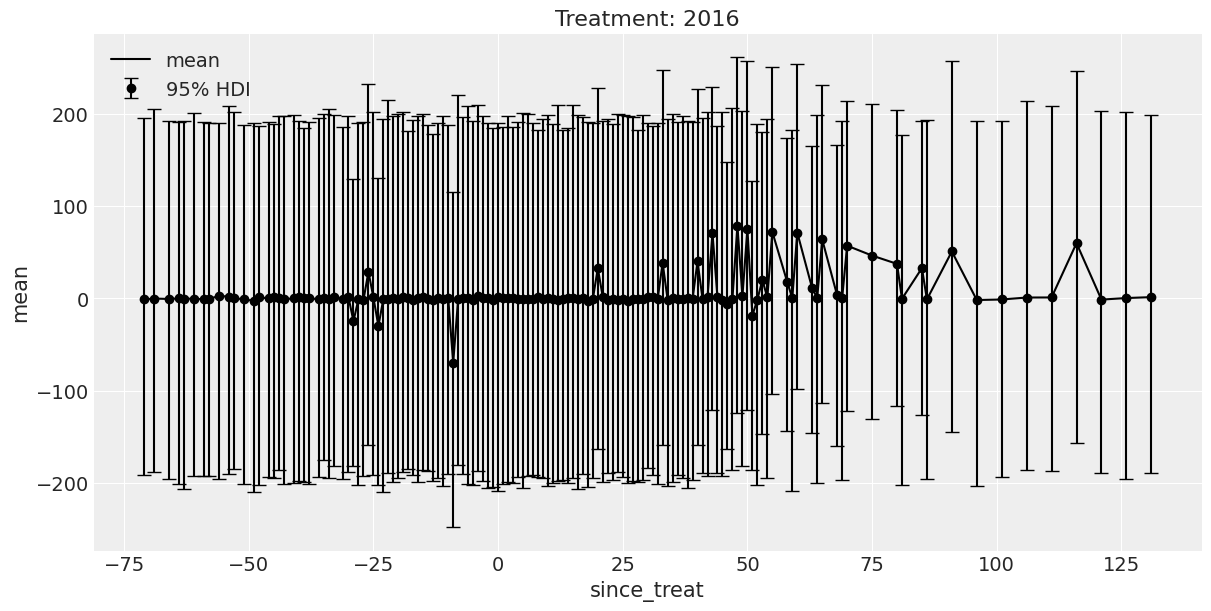

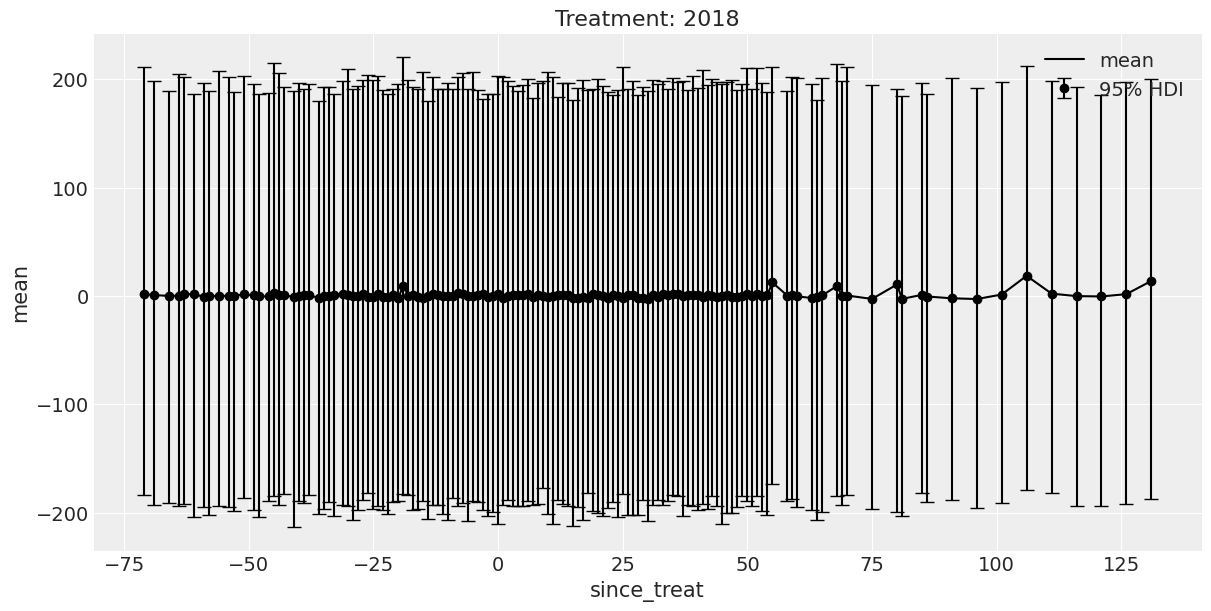

In [58]:
def plot_delta_treat(delta_df, treat):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='since_treat',
        y='mean',
        data=delta_df[delta_df['treat'] == treat],
        color='black',
        label='mean'
    )
    plt.errorbar(
        x=delta_df[delta_df['treat'] == treat]['since_treat'],
        y=delta_df[delta_df['treat'] == treat]['mean'],
        yerr=[
            delta_df[delta_df['treat'] == treat]['mean'] - delta_df[delta_df['treat'] == treat]['hdi_2.5%'],
            delta_df[delta_df['treat'] == treat]['hdi_97.5%'] - delta_df[delta_df['treat'] == treat]['mean']
        ],
        fmt='o',
        capsize=5,
        color='black',
        label='95% HDI'
    )
    plt.title(f'Treatment: {treat}')
    plt.legend()
    plt.show()

treat_list = df['year_bridges_opened'].unique()
treat_list.sort()
for treat in treat_list:
    plot_delta_treat(delta_df, treat)

In [ ]:
def plot_effects_over_time(delta_df):
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        x='time_since_intervention',
        y='mean',
        data=delta_df,
        marker='o',
        color='black',
        label='Mean'
    )
    # エラーバー
    plt.errorbar(
        x=delta_df['time_since_intervention'],
        y=delta_df['mean'],
        yerr=[
            delta_df['mean'] - delta_df['hdi_2.5%'],
            delta_df['hdi_97.5%'] - delta_df['mean']
        ],
        fmt='o',
        color='black',
        alpha=0.5,
        capsize=5,
        label='95% HDI'
    )
    plt.axvline(x=0, color='black', linestyle=':')
    plt.axhline(y=0, color='black', linestyle=':')
    plt.xlabel('Time since Treatment')
    plt.ylabel('Effects')
    plt.title('Effects Over Time')
    plt.legend()
    plt.show()

## 階層ベイズモデル

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pymc/model/core.py:1359: ImputationWarning: Data in y_obs contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)


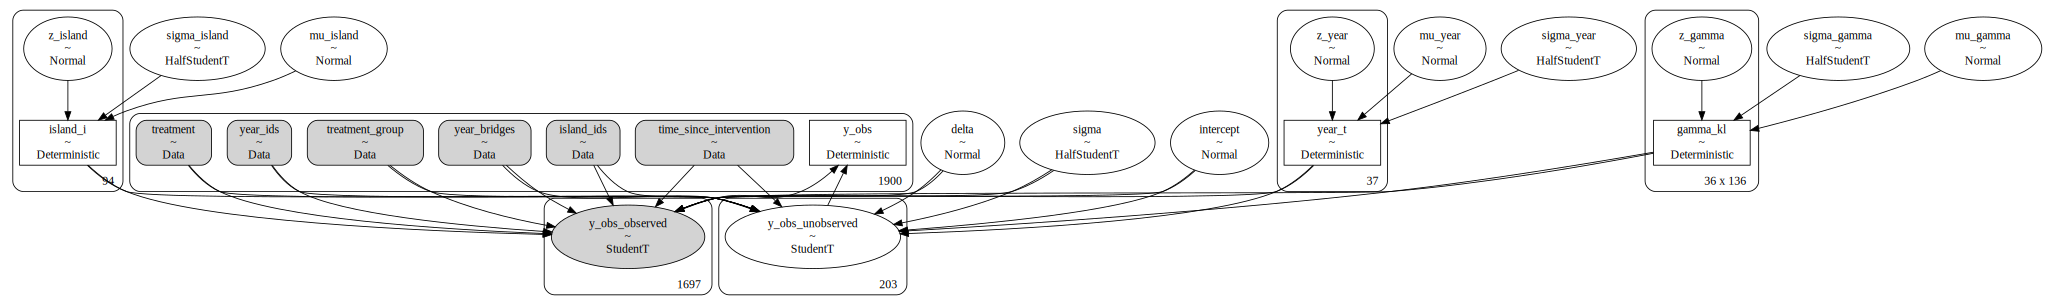

In [17]:
# 0から始まるインデックスを振り直す
df['island_ids'], unique_island_ids = pd.factorize(df['island_ids'])
df['years'], unique_year_ids = pd.factorize(df['years'])
df['year_bridges_opened'], unique_year_bridges_opened = pd.factorize(df['year_bridges_opened'])
unique_time_since_intervention = len(df['time_since_intervention'].unique())
unique_year_bridges_opened = len(df['year_bridges_opened'].unique())

with pm.Model() as fully_saturated_h:
    # data
    island_ids = pm.Data('island_ids', df['island_ids'])
    year_ids = pm.Data('year_ids', df['years'])
    treatment = pm.Data('treatment', df['after_treated'])
    treatment_group = pm.Data('treatment_group', df['treatment_group'])
    time_since_intervention = pm.Data('time_since_intervention', df['time_since_intervention'])
    year_bridges = pm.Data('year_bridges', df['year_bridges_opened'])

    # priors
    # random effects
    mu_island = pm.Normal('mu_island', mu=0, sigma=100)
    sigma_island = pm.HalfStudentT('sigma_island', nu=3, sigma=100)
    z_island = pm.Normal('z_island', mu=0, sigma=1, shape=len(unique_island_ids))
    island_i = pm.Deterministic('island_i', mu_island + sigma_island * z_island)

    mu_year = pm.Normal('mu_year', mu=0, sigma=100)
    sigma_year = pm.HalfStudentT('sigma_year', nu=3, sigma=100)
    z_year = pm.Normal('z_year', mu=0, sigma=1, shape=len(unique_year_ids))
    year_t = pm.Deterministic('year_t', mu_year + sigma_year * z_year)

    mu_gamma = pm.Normal('mu_gamma', mu=0, sigma=100)
    sigma_gamma = pm.HalfStudentT('sigma_gamma', nu=3, sigma=100)
    z_gamma = pm.Normal('z_gamma', mu=0, sigma=1, shape=(unique_year_bridges_opened, unique_time_since_intervention))
    gamma_kl = pm.Deterministic('gamma_kl', mu_gamma + sigma_gamma * z_gamma)

    # fixed effects
    intercept = pm.Normal('intercept', mu=0, sigma=100)
    delta = pm.Normal('delta', mu=0, sigma=100)
    sigma = pm.HalfStudentT('sigma', nu=3, sigma=100)

    # expectation
    mu = intercept + island_i[island_ids] + year_t[year_ids] + delta * treatment + gamma_kl[year_bridges, time_since_intervention] * treatment_group

    # likelihood
    y_obs = pm.StudentT('y_obs', nu=3, mu=mu, sigma=sigma, observed=df['populations'])

pm.model_to_graphviz(fully_saturated_h)

In [18]:
with fully_saturated_h:
    trace_fully_saturated_h = pm.sample(
        draws=2000,
        tune=2000,
        chains=2,
        cores=6,
        nuts_sampler='numpyro',
        random_seed=42
    )
    pm.compute_log_likelihood(trace_fully_saturated_h)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [20]:
az.summary(trace_fully_saturated_h, var_names=['intercept', 'delta', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,59.818,94.076,-120.250,243.967,6.166,4.365,233.0,645.0,1.00
delta,-311.627,47.577,-402.629,-226.752,5.441,4.039,83.0,74.0,1.04
sigma,46.034,1.915,42.433,49.734,0.090,0.064,450.0,1272.0,1.03


In [22]:
az.waic(trace_fully_saturated_h)

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/arviz/stats/stats.py:1653: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 1697 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -11751.45   221.88
p_waic     1529.57        -

There has been a warning during the calculation. Please check the results.

## サンプリングの保存

In [19]:
az.to_netcdf(trace_fully_saturated, './sample/trace_fully_saturated.nc')
az.to_netcdf(trace_fully_saturated_h, './sample/trace_fully_saturated_h.nc')

'./sample/trace_fully_saturated_h.nc'